In [1]:
import utils
import numpy
from scipy.interpolate import griddata
from matplotlib import pyplot as plt
import cmocean
import pandas
import datetime
import netCDF4
from matplotlib import ticker
import gsw
import matplotlib
from matplotlib.dates import date2num
import warnings
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')
import importlib # to be able to reload user modules with importlib.reload(utils)
importlib.reload(utils)
import limits_ranges
importlib.reload(limits_ranges)
import xarray
import string
from scipy import stats

dfnew, newprofiles = utils.create_dataframe(pfloat='new', force_reconstruction=False)
dfold, oldprofiles = utils.create_dataframe(pfloat='old', force_reconstruction=False)
#dfold[(dfold['sal']<34.1) & (dfold['cyk']==64)] = numpy.nan
dfold = dfold.drop(dfold[(dfold['sal']<34.1) & (dfold['cyk']==64)].index)
#dfsoc, socprofiles = utils.create_dataframe(pfloat='5904468_Mprof.nc', force_reconstruction=False)
limits = limits_ranges.full_range()


Returning previously computed DataFrame...
Returning previously computed DataFrame...


Idea for a change:
* Combine bathymetry depth with int salinity and int temperature lineplots.
* add a second column at the side showing the corresponding profiles. 
* have temperature and salinity only in Figure 2
* delete figure 3
* Have density in Figure 4
--> no density profiles any longer. Is that a problem?

The length of the mld is 500
error or skip: no density value: 27.81
The length of the mld is 500


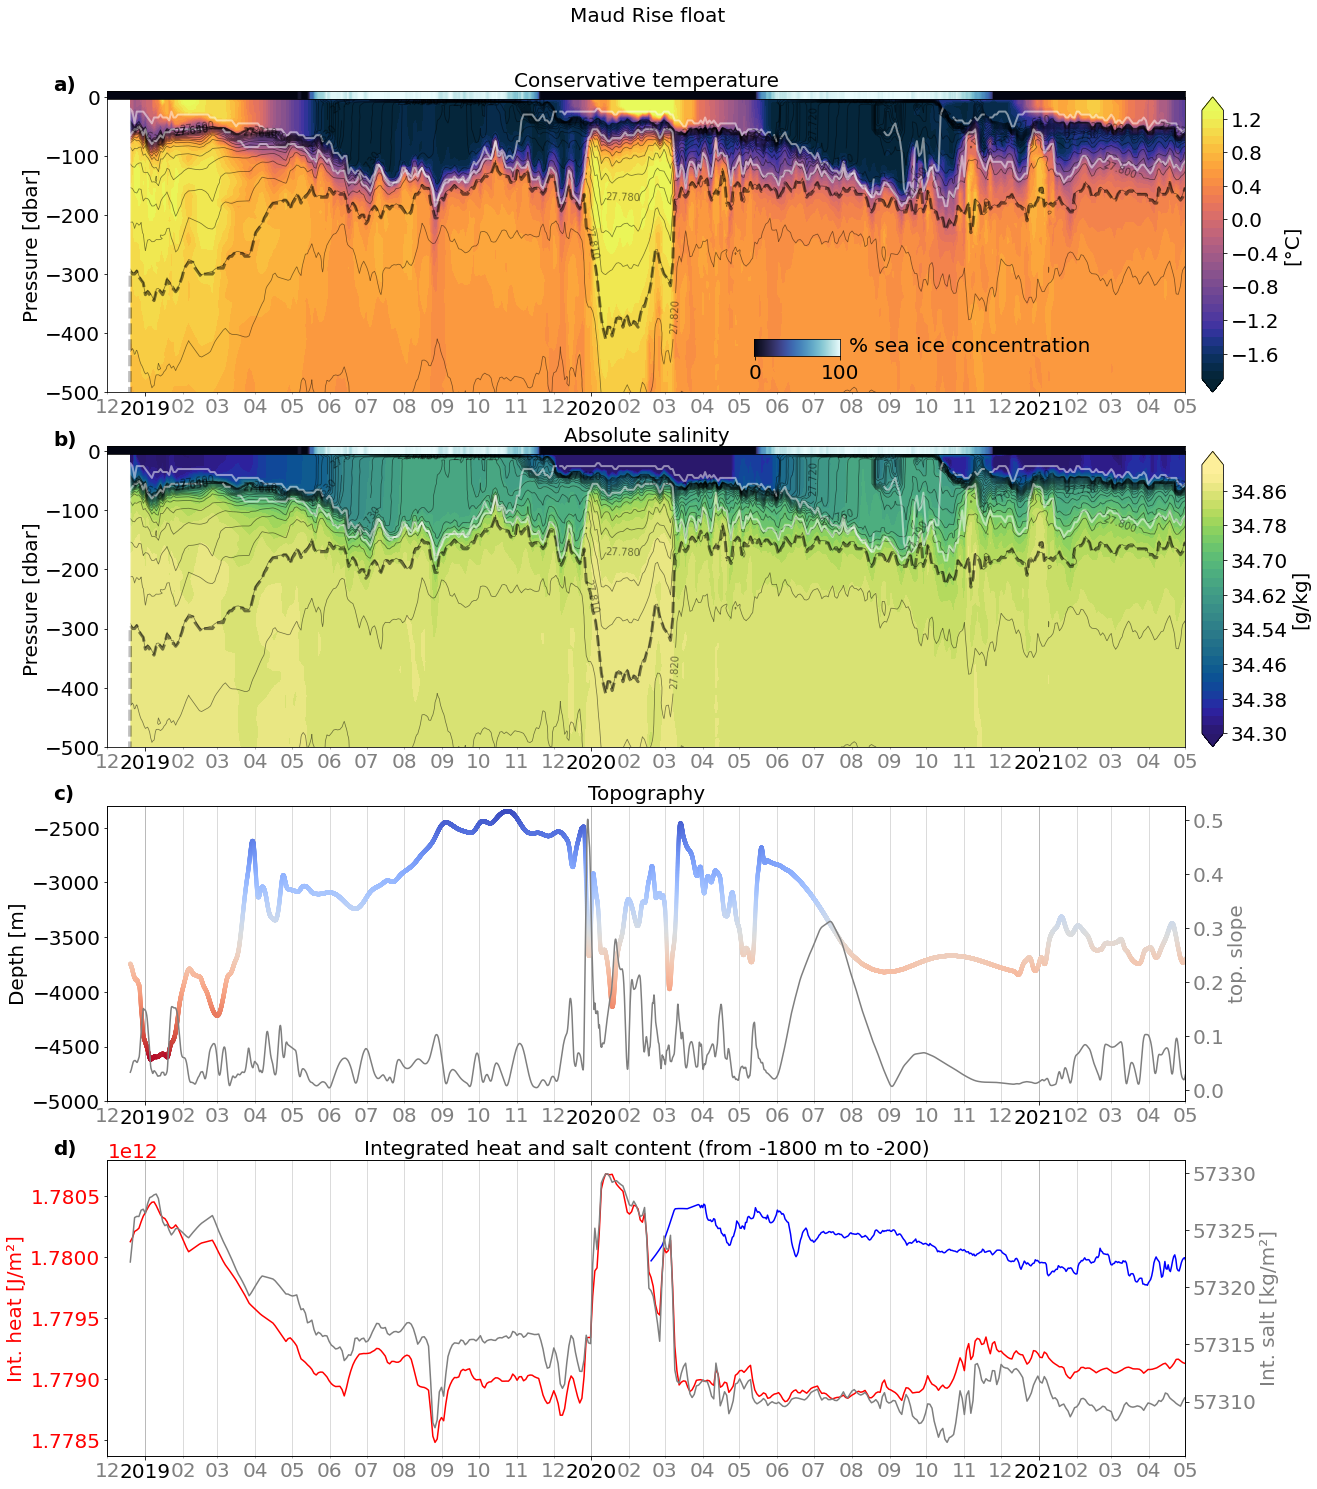

In [2]:
plt.rc('font', size=20) # 18 is original size
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
importlib.reload(utils)

df = dfold
#df_col = xarray.open_dataset('../data/collocation_300234068638900.nc')#
df_col = xarray.open_dataset('../data/collocation_300234067208900.nc')

advar = {}
mld = utils.create_mld(df)
mld[mld>-20] = numpy.nan
ww = utils.create_ww_lower(df)
isopycnal1_den_depth, _ = utils.create_isopycnal(
    df, variable='den',density_value=27.81) # need to be adapted for 'dens', 'gamman'...

#fig, axs = plt.subplots(nrows=5, figsize=[20,20], sharex=True)

fig, axsc = plt.subplots(nrows=4,figsize=(20,25),ncols=2, #20,25 is original size
             gridspec_kw={"width_ratios":[1, 0.02], "wspace":0.03})
#plt.subplots_adjust(wspace=0.01)
axs = axsc[:,0]
fig.suptitle('Maud Rise float', fontsize=20, y=0.93)

limits.maxs['den'] = 27.9
limits.mins['den'] = 27.6
limits.steplengths['den'] = 0.01
limits.maxs['tem'] = 1.3
limits.mins['sal'] = 34.3

cbars = []

for index, variable in enumerate(['tem', 'sal']):

    xi, yi, grid_z0 = utils.create_datagrid(df=df, variable=variable)
    colors = utils.create_contourplot(
        xi=xi, yi=yi, grid_z0=grid_z0, ax=axs[index], maxdepth=500, 
        cmap=limits.mcolors[variable],vmin=limits.mins[variable], 
        vmax=limits.maxs[variable], steplength=limits.steplengths[variable], 
        locator=limits.locators[variable], contour=False)
    
    # plot the density contours over:
    xi, yi, grid_z0 = utils.create_datagrid(df=df, variable='den')
    lines = utils.create_contourplot(
        xi=xi, yi=yi, grid_z0=grid_z0, ax=axs[index], maxdepth=500, 
        cmap=limits.mcolors['den'],vmin=limits.mins['den'], 
        vmax=limits.maxs['den'], steplength=limits.steplengths['den'], 
        locator=limits.locators['den'], contourf=False, linewidths=0.75)
    axs[index].clabel(lines, inline=1, fontsize=10)
    # end plotting the density contours over
    cbar = fig.colorbar(mappable=colors, cax=axsc[index,1])
    cbars.append(cbar)
    axs[index].set_title(limits.titles[variable], fontsize=20, pad=10)
    xi = [datetime.datetime.fromtimestamp(fdate) for fdate in xi]
    #axs[index].plot(matplotlib.dates.date2num(xi), isopycnal1_gamman_depth, 
    #                color='k', ls='--',lw=3, alpha=0.5)
    axs[index].plot(matplotlib.dates.date2num(xi), isopycnal1_den_depth, 
                    color='k', ls='--',lw=3, alpha=0.5)
    axs[index].plot(matplotlib.dates.date2num(xi), mld, color='white', lw=2, alpha=0.5)
    axs[index].plot(matplotlib.dates.date2num(xi), ww, color='white', lw=2, alpha=0.5)
    axs[index].set_ylabel('Pressure [dbar]')

cbars[0].set_label('[°C]')
cbars[1].set_label('[g/kg]')
# constant values that I derived by simply differentiating the etopo file grid distances
dlon=0.5285675796756327
dlat=1.8537723761841156
df_col['yslope'] = df_col['depth_topo_grady']/(dlat*1000)
df_col['xslope'] = df_col['depth_topo_gradx']/(dlon*1000)
df_col['slope'] = numpy.sqrt(df_col['yslope']**2+df_col['xslope']**2)

tax = matplotlib.dates.date2num(df_col['time'])
depth_topo = df_col['depth_topo']
depth_topo_grady = df_col['depth_topo_grady']

topo_slope = numpy.sqrt(df_col['xslope']**2+df_col['yslope']**2)
s = depth_topo.rolling(time=72, center=True).mean()
t = tax
lower = -3000

slower = numpy.ma.masked_where(s > lower, s)
smiddle = numpy.ma.masked_where((s < lower), s)

# this part is using scatter to color the topographical depth
norm = matplotlib.colors.Normalize(vmin=-4000.0, vmax=-3000.0)
cmap = plt.cm.coolwarm_r
colors = axs[2].scatter(tax, s, s=10,c=s, cmap=cmap, zorder=5)
cbar = fig.colorbar(mappable=colors, cax=axsc[2,1])


#axs[2].plot(tax, depth_topo.rolling(time=72, center=True).mean(), color='black')
axs[2].set_ylabel('Depth [m]')

ax2 = axs[2].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:grey'
ax2.set_ylabel('top. slope', color=color)  # we already handled the x-label with ax1
ax2.plot(tax, topo_slope.rolling(time=72, center=True).mean(), color=color)

ax2.tick_params(axis='y', labelcolor=color)
utils.style_timeaxis(axs[2])
axs[2].set_title('Topography', fontsize=20)
axs[2].set_ylim(-5000,-2300)
#ax2.plot(tax, df_col['yslope'], color='lightgrey')

advar['mld'] = utils.create_mld(df)
from_depth=-1800
to_depth = -200 # -15
advar['heat'] = utils.integrate(df, variable='tem', 
                                from_depth=from_depth, 
                                to_depth=to_depth)
advar['salt'] = utils.integrate(df, variable='sal', from_depth=from_depth, 
                                to_depth=to_depth)
advar['nsqc'] = utils.integrate(df, variable='nsq', from_depth=from_depth, 
                                to_depth=to_depth)

axs[3].plot(xi[1:-1], advar['heat'][1:-1], color='red')
axs[3].tick_params(axis='y', labelcolor='red')
axs[3].set_ylabel('Int. heat [J/m²]', color='red')

ax3 = axs[3].twinx()
color = 'tab:grey'
ax3.set_ylabel('Int. salt [kg/m²]', color=color)  # we already handled the x-label with ax1
ax3.plot(xi[1:-1], advar['salt'][1:-1], color=color)
ax3.tick_params(axis='y', labelcolor=color)
axs[3].set_title('Integrated heat and salt content (from %s m to %s)'%(from_depth,to_depth), fontsize=20)
utils.style_timeaxis(axs[3])

# plot the integrated values of the Reference Float for comparison
xi, yi, grid_z0 = utils.create_datagrid(df=dfnew, variable=variable)
advar['heat'] = utils.integrate(dfnew, variable='tem', 
                                from_depth=from_depth, 
                                to_depth=to_depth)
advar['salt'] = utils.integrate(dfnew, variable='sal', from_depth=from_depth, 
                                to_depth=to_depth)
xi = [datetime.datetime.fromtimestamp(fdate) for fdate in xi]
axs[3].plot(xi[1:-3], advar['heat'][1:-3], color='blue')
# end plot the integrated values of the Reference Float

colors = ['lightgrey', 'darkgrey', 'skyblue', 'olive']
colors = ['grey', 'k']
linestyles = ['--', 'solid']

axsc[2,1].remove()
axsc[3,1].remove()
#axsc[4,1].remove()

for i in range(0,len(axs)):#[0,1,2,3,4]:
    axs[i].set_xlim(datetime.date(2018,12,1), datetime.date(2021,5,1))
    
for n, ax in enumerate(axs):   
    ax.text(-0.05, 1.02, string.ascii_lowercase[n]+')', transform=ax.transAxes, 
            size=20, weight='bold')


from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#axins2 = inset_axes(axsc[0][0], width='100%',height=2, loc=9)#,height="10%)

for index in [0,1]:
    axins = inset_axes(axsc[index][0], width="100%", height="100%",
                   bbox_to_anchor=(0.0, .955, 1., .1),
                   bbox_transform=axsc[index][0].transAxes, loc=2, borderpad=0)
    if index == 0:
        colorbaraxins = inset_axes(axsc[index][0], width="20%", height="100%",
                       bbox_to_anchor=(0.6, 0.1, 0.4, .1),
                       bbox_transform=axsc[index][0].transAxes, loc=2, borderpad=0)
        colorbaraxins.imshow(numpy.array([numpy.linspace(0,100,101),numpy.linspace(0,100,101)]),
                             cmap=cmocean.cm.ice,vmin=0,vmax=100,
                             aspect=10)
        colorbaraxins.set_yticks([])
        colorbaraxins.set_yticklabels([])
        colorbaraxins.text(x=1.1, y=0.3, s='% sea ice concentration', transform=colorbaraxins.transAxes)
    
    
    df_col.sel(expver=5)['siconc'][numpy.isnan(df_col.sel(expver=5)['siconc'])]=0
    A = df_col.sel(expver=5)['siconc']
    A[numpy.isnan(A)] = 0
    A = numpy.array([A, A])
    axins.imshow(A, aspect=80, cmap=cmocean.cm.ice,zorder=-5)

    axins.set_xticks([])
    axins.set_xticklabels([])
    axins.set_yticks([])
    axins.set_yticklabels([])

plt.savefig('../plots/figures/figure2.png', dpi=200)


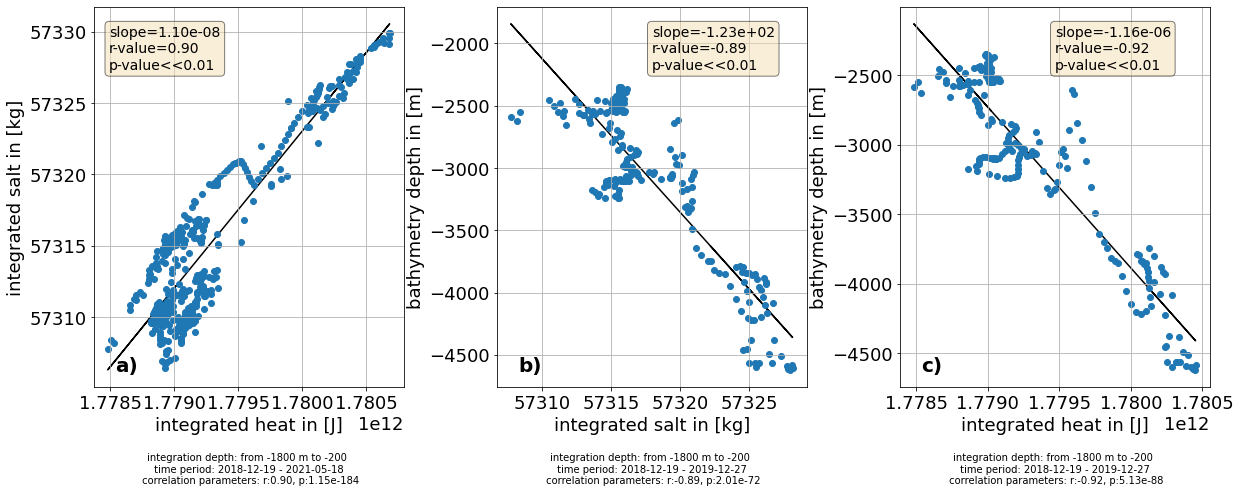

In [3]:
plt.rc('font', size=18) 
#endpoint of correlation:
#print('considering data from %s to %s'%(xi[start].date(), xi[end].date()))

def create_scatterplot(x,y, ax, bboxposition):

    ax.scatter(x['data'],y['data'])
    mask = ~numpy.isnan(x['data']) & ~numpy.isnan(y['data']) # because linregress cannot handle nans
    slope, intercept, r, p, se = stats.linregress(x['data'][mask],y['data'][mask])#advar['heat'][1:-1], advar['salt'][1:-1])
    ax.plot(x['data'][mask],intercept+slope*x['data'][mask], color='k', zorder=-1)
    # print(intercept ,slope)
    ax.set_xlabel(x['label'])
    ax.set_ylabel(y['label'])
    #plt.title('integration depth: from %s m to %s'%(from_depth,to_depth))
    txt='integration depth: from {} m to {} \n time period: {} - {} \n correlation parameters: r:{:.2f}, p:{:.2e}'.format(
        from_depth,to_depth,xi[start].date(), xi[end].date(),r,p)
    ax.text(0.5, -0.25, txt, wrap=True, horizontalalignment='center', fontsize=10, transform=ax.transAxes)
    
    textstr = '\n'.join((
    'slope=%.2e' % (slope, ),
    'r-value=%.2f' % (r, ),
    'p-value<<0.01'))#'%.2e' % (p, )))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

     
    # place a text box in upper left in axes coords
    ax.text(bboxposition, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', horizontalalignment='left',
            bbox=props)
    
    ax.grid()
    #ax.show()

fig, axs = plt.subplots(figsize=[20,7], ncols=3, gridspec_kw=dict(wspace=0.3))
    
start = 1
end = 499 # 226 is the end of 2019 for dfold, and gives good correlation coefficients

int_heat = {'data':advar['heat'][start:end], 'label':'integrated heat in [J]'}
int_salt = {'data':advar['salt'][start:end], 'label':'integrated salt in [kg]'}
depth = {'data':depth_topo.interp(time=xi[start:end]), 'label':'bathymetry depth in [m]'}
    
x=int_heat
y=int_salt
create_scatterplot(x,y,axs[0], 0.05)

start = 1
end = 212 # 226/212 is the end of 2019 for dfold, and gives good correlation coefficients

int_heat = {'data':advar['heat'][start:end], 'label':'integrated heat in [J]'}
int_salt = {'data':advar['salt'][start:end], 'label':'integrated salt in [kg]'}
depth = {'data':depth_topo.interp(time=xi[start:end]), 'label':'bathymetry depth in [m]'}

y = depth
x = int_salt
create_scatterplot(x,y,axs[1], 0.5)

y = depth
x = int_heat
create_scatterplot(x,y,axs[2], 0.5)

for n, ax in enumerate(axs):   
    ax.text(0.07, 0.04, string.ascii_lowercase[n]+')', transform=ax.transAxes, 
            size=20, weight='bold')

plt.savefig('../plots/figures/suppl1.png', dpi=200)
#print(xi[230])

The length of the mld is 500
error or skip: no density value: 27.81
The length of the mld is 500
error or skip: no density value: 27.82
error or skip: no density value: 27.83


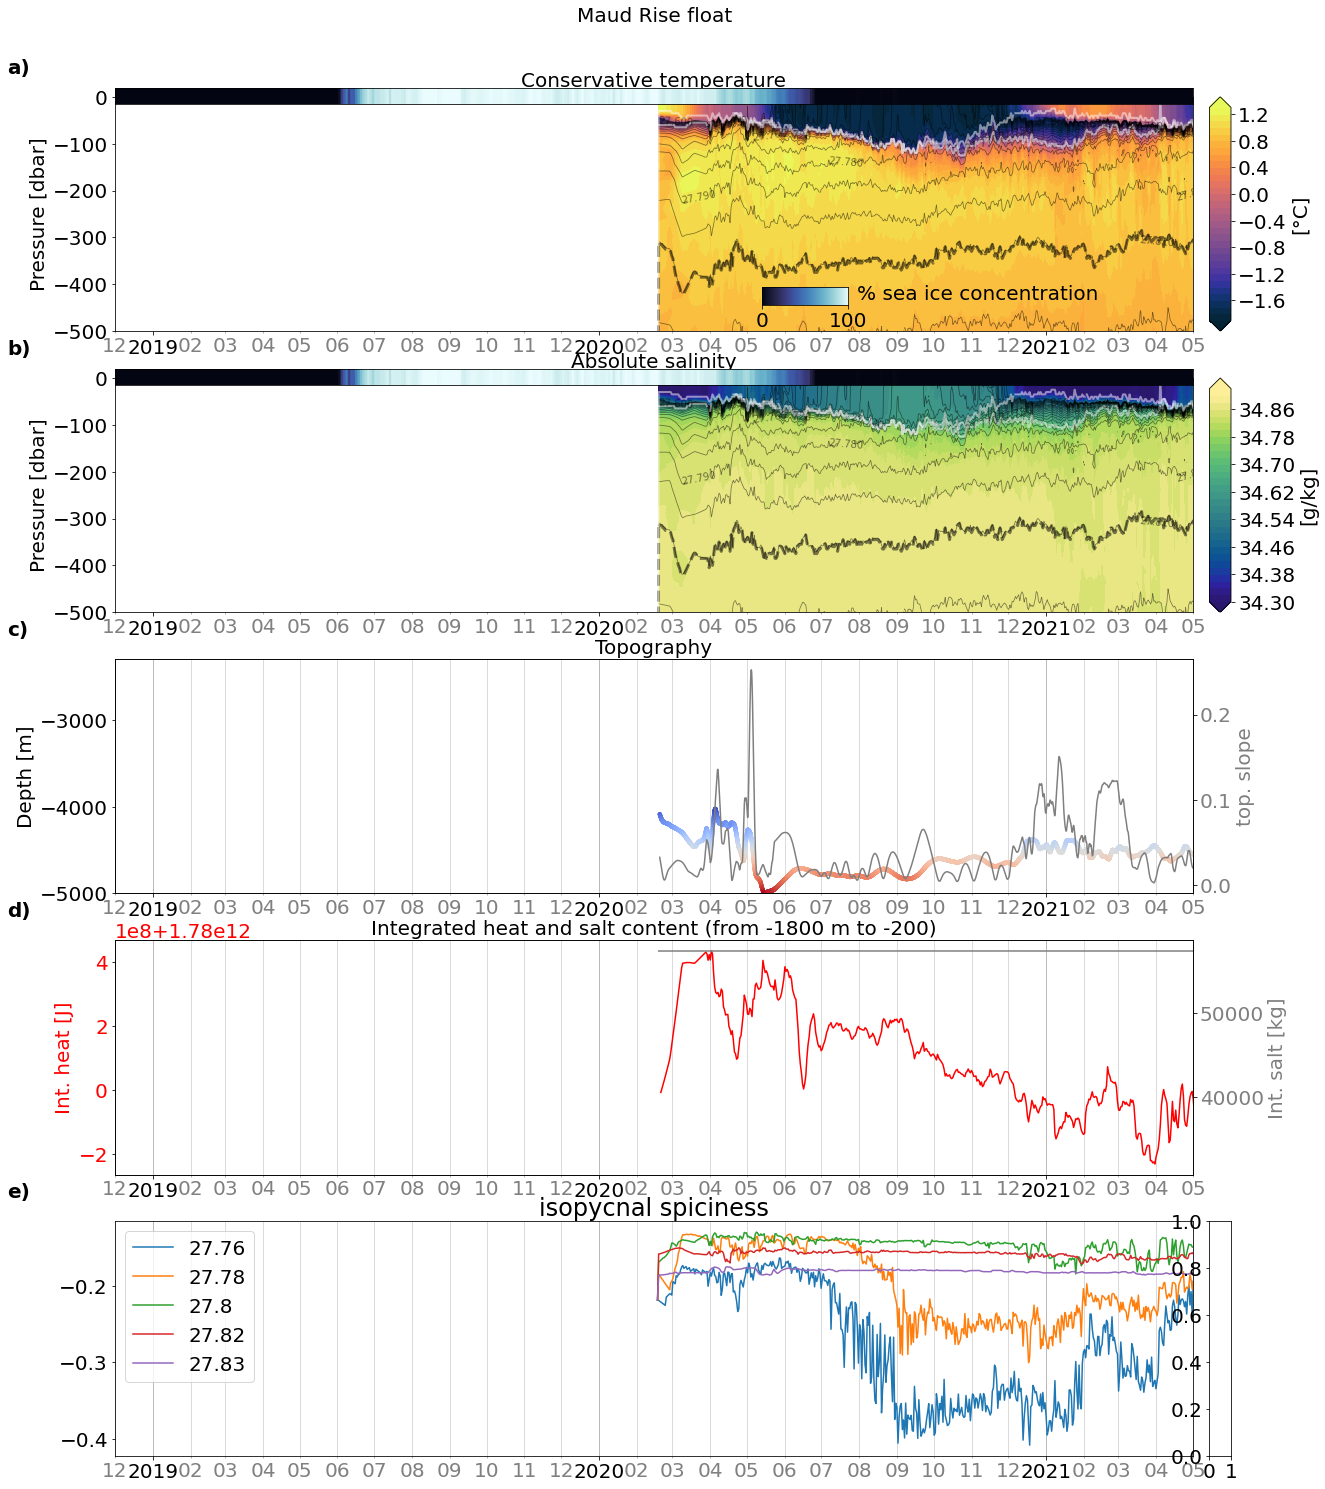

In [9]:
plt.rc('font', size=20) # 18 is original size
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
importlib.reload(utils)

df = dfnew
df_col = xarray.open_dataset('../data/collocation_300234068638900.nc')#
#df_col = xarray.open_dataset('../data/collocation_300234067208900.nc')

advar = {}
mld = utils.create_mld(df)
mld[mld>-20] = numpy.nan
ww = utils.create_ww_lower(df)
isopycnal1_gamman_depth, isopycnal1_gamman_spice = utils.create_isopycnal(
    df, variable='gamman',density_value=28.1) # need to be adapted for 'dens', 'gamman'...
isopycnal1_den_depth, _ = utils.create_isopycnal(
    df, variable='den',density_value=27.81) # need to be adapted for 'dens', 'gamman'...

#fig, axs = plt.subplots(nrows=5, figsize=[20,20], sharex=True)

fig, axsc = plt.subplots(nrows=5,figsize=(20,25),ncols=2, #20,25 is original size
             gridspec_kw={"width_ratios":[1, 0.02], "wspace":0.03})
#plt.subplots_adjust(wspace=0.01)
axs = axsc[:,0]
fig.suptitle('Maud Rise float', fontsize=20, y=0.93)

limits.maxs['den'] = 27.9
limits.mins['den'] = 27.6
limits.steplengths['den'] = 0.01
limits.maxs['tem'] = 1.3
limits.mins['sal'] = 34.3

cbars = []

for index, variable in enumerate(['tem', 'sal']):

    xi, yi, grid_z0 = utils.create_datagrid(df=df, variable=variable)
    colors = utils.create_contourplot(
        xi=xi, yi=yi, grid_z0=grid_z0, ax=axs[index], maxdepth=500, 
        cmap=limits.mcolors[variable],vmin=limits.mins[variable], 
        vmax=limits.maxs[variable], steplength=limits.steplengths[variable], 
        locator=limits.locators[variable], contour=False)
    
    # plot the density contours over:
    xi, yi, grid_z0 = utils.create_datagrid(df=df, variable='den')
    lines = utils.create_contourplot(
        xi=xi, yi=yi, grid_z0=grid_z0, ax=axs[index], maxdepth=500, 
        cmap=limits.mcolors['den'],vmin=limits.mins['den'], 
        vmax=limits.maxs['den'], steplength=limits.steplengths['den'], 
        locator=limits.locators['den'], contourf=False, linewidths=0.75)
    axs[index].clabel(lines, inline=1, fontsize=10)
    
    # plot the gamman density contours over:
    #xi, yi, grid_z0 = utils.create_datagrid(df=df, variable='gamman')
    #lines = utils.create_contourplot(
    #    xi=xi, yi=yi, grid_z0=grid_z0, ax=axs[index], maxdepth=500, 
    #    cmap=limits.mcolors['gamman'],vmin=limits.mins['gamman'], 
    #    vmax=limits.maxs['gamman'], steplength=limits.steplengths['den'], 
    #    locator=limits.locators['gamman'], contourf=False, linewidths=2)
    
    # end plotting the density contours over
    cbar = fig.colorbar(mappable=colors, cax=axsc[index,1])
    cbars.append(cbar)
    # cb1.set_label('bathymetry slope')
    axs[index].set_title(limits.titles[variable], fontsize=20, pad=10)
    xi = [datetime.datetime.fromtimestamp(fdate) for fdate in xi]
    #axs[index].plot(matplotlib.dates.date2num(xi), isopycnal1_gamman_depth, 
    #                color='k', ls='--',lw=3, alpha=0.5)
    axs[index].plot(matplotlib.dates.date2num(xi), isopycnal1_den_depth, 
                    color='k', ls='--',lw=3, alpha=0.5)
    axs[index].plot(matplotlib.dates.date2num(xi), mld, color='white', lw=2, alpha=0.5)
    axs[index].plot(matplotlib.dates.date2num(xi), ww, color='white', lw=2, alpha=0.5)
    axs[index].set_ylabel('Pressure [dbar]')

cbars[0].set_label('[°C]')
cbars[1].set_label('[g/kg]')
# constant values that I derived by simply differentiating the etopo file grid distances
dlon=0.5285675796756327
dlat=1.8537723761841156
df_col['yslope'] = df_col['depth_topo_grady']/(dlat*1000)
df_col['xslope'] = df_col['depth_topo_gradx']/(dlon*1000)
df_col['slope'] = numpy.sqrt(df_col['yslope']**2+df_col['xslope']**2)

tax = matplotlib.dates.date2num(df_col['time'])
depth_topo = df_col['depth_topo']
depth_topo_grady = df_col['depth_topo_grady']

# deprecated!
# topo_slope = numpy.sqrt(df_col['depth_topo_grady']**2+df_col['depth_topo_gradx']**2)

topo_slope = numpy.sqrt(df_col['xslope']**2+df_col['yslope']**2)
s = depth_topo.rolling(time=72, center=True).mean()
t = tax
lower = -3000

slower = numpy.ma.masked_where(s > lower, s)
smiddle = numpy.ma.masked_where((s < lower), s)

#axs[2].plot(t, smiddle, color='tab:blue')
#axs[2].plot(t, slower, color='tab:red')

# this part is using scatter to color the topographical depth
norm = matplotlib.colors.Normalize(vmin=-4000.0, vmax=-3000.0)
cmap = plt.cm.coolwarm_r
colors = axs[2].scatter(tax, s, s=10,c=s, cmap=cmap, zorder=5)
cbar = fig.colorbar(mappable=colors, cax=axsc[2,1])


#axs[2].plot(tax, depth_topo.rolling(time=72, center=True).mean(), color='black')
axs[2].set_ylabel('Depth [m]')

ax2 = axs[2].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:grey'
ax2.set_ylabel('top. slope', color=color)  # we already handled the x-label with ax1
ax2.plot(tax, topo_slope.rolling(time=72, center=True).mean(), color=color)

ax2.tick_params(axis='y', labelcolor=color)
utils.style_timeaxis(axs[2])
axs[2].set_title('Topography', fontsize=20)
axs[2].set_ylim(-5000,-2300)
#ax2.plot(tax, df_col['yslope'], color='lightgrey')

advar['mld'] = utils.create_mld(df)
#advar['isopycnal'], advar['isopycnal_spice'] = utils.create_isopycnal(
#    df=df, variable='den', density_value=27.66)
#advar['isopycnal'], advar['isopycnal_spice'] = utils.create_isopycnal(
#    df=df, variable='den', density_value=27.66)
#27.66)
from_depth=-1800
to_depth = -200 # -15
advar['heat'] = utils.integrate(df, variable='tem', 
                                from_depth=from_depth, 
                                to_depth=to_depth)
advar['salt'] = utils.integrate(df, variable='sal', from_depth=from_depth, 
                                to_depth=to_depth)
advar['nsqc'] = utils.integrate(df, variable='nsq', from_depth=from_depth, 
                                to_depth=to_depth)

axs[3].plot(xi[3:-3], advar['heat'][3:-3], color='red')
axs[3].tick_params(axis='y', labelcolor='red')
axs[3].set_ylabel('Int. heat [J]', color='red')
ax3 = axs[3].twinx()
color = 'tab:grey'
ax3.set_ylabel('Int. salt [kg]', color=color)  # we already handled the x-label with ax1
ax3.plot(xi[1:-1], advar['salt'][1:-1], color=color)
ax3.tick_params(axis='y', labelcolor=color)
axs[3].set_title('Integrated heat and salt content (from %s m to %s)'%(from_depth,to_depth), fontsize=20)
utils.style_timeaxis(axs[3])

colors = ['lightgrey', 'darkgrey', 'skyblue', 'olive']
colors = ['grey', 'k']
linestyles = ['--', 'solid']

"""
axs[4].plot(xi[1:-1], isopycnal1_gamman_spice[1:-1], color='k')
utils.style_timeaxis(axs[4])
axs[4].set_title('isopycnal spice')
axs[4].set_ylabel('kg/m³')
"""

axsc[2,1].remove()
axsc[3,1].remove()
#axsc[4,1].remove()

for i in range(0,len(axs)):#[0,1,2,3,4]:
    axs[i].set_xlim(datetime.date(2018,12,1), datetime.date(2021,5,1))
    
for n, ax in enumerate(axs):   
    ax.text(-0.1, 1.1, string.ascii_lowercase[n]+')', transform=ax.transAxes, 
            size=20, weight='bold')

for density_value in [27.76, 27.78, 27.80, 27.82, 27.83]:
    advar['isopycnal'], advar['isopycnal_spice'] = utils.create_isopycnal(
        df=df, variable='den', density_value=density_value)#27.66)
    axs[4].plot(xi, advar['isopycnal_spice'], label=density_value)
axs[4].legend()
axs[4].set_title('isopycnal spiciness')
utils.style_timeaxis(axs[4])
    
"""    
for i,upperdepthlimit in enumerate([250,500]):
    
    rms, indices, dates = utils.compute_diapycnal_spice_variations(
                                       oldprofiles, 
                                       upperdepthlimit=upperdepthlimit, 
                                       lowerdepthlimit=1800, )
    #axs[4].set_legend()

    # axs[4].plot(dates,rms, color=colors[i], ls=linestyles[i],label='below %s m'%upperdepthlimit)
    
    axs[4].grid()
    #axs[4].set_ylim(-0.1e-5,2e-5)
    #axs[4].ax.set_yscale('log')
    axs[4].legend()
    axs[4].set_title('rms diapycnal spiciness curvature')
utils.style_timeaxis(axs[4])
"""
#axsc[4,1].remove()

    #plt.show()

# --- the following is just printing the sea ice contentration and colorbars --- #
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
for index in [0,1]:
    axins = inset_axes(axsc[index][0], width="100%", height="100%",
                   bbox_to_anchor=(0.0, .955, 1., .1),
                   bbox_transform=axsc[index][0].transAxes, loc=2, borderpad=0)
    if index == 0:
        colorbaraxins = inset_axes(axsc[index][0], width="20%", height="100%",
                       bbox_to_anchor=(0.6, 0.1, 0.4, .1),
                       bbox_transform=axsc[index][0].transAxes, loc=2, borderpad=0)
        colorbaraxins.imshow(numpy.array([numpy.linspace(0,100,101),numpy.linspace(0,100,101)]),
                             cmap=cmocean.cm.ice,vmin=0,vmax=100,
                             aspect=10)
        colorbaraxins.set_yticks([])
        colorbaraxins.set_yticklabels([])
        colorbaraxins.text(x=1.1, y=0.3, s='% sea ice concentration', transform=colorbaraxins.transAxes)
    
    
    df_col.sel(expver=5)['siconc'][numpy.isnan(df_col.sel(expver=5)['siconc'])]=0
    A = df_col.sel(expver=5)['siconc']
    A[numpy.isnan(A)] = 0
    A = numpy.array([A, A])
    axins.imshow(A, aspect=80, cmap=cmocean.cm.ice,zorder=-5)
    
    axins.set_xticks([])
    axins.set_xticklabels([])
    axins.set_yticks([])
    axins.set_yticklabels([])
# --- end sea ice concentration inset --- #

plt.savefig('../plots/figures/figure2_new2.png', dpi=200)
